In [1]:
import vio_ort
import matplotlib.pyplot as plt
import os
import json
import numpy as np
import cv2
import concurrent.futures
import threading
from collections import defaultdict

In [2]:
lat_VIO = []
lon_VIO = []

odometry = vio_ort.VIO(lat0=54.889668, lon0=83.1258973333, alt0=0)

# Путь к папке
set_dir = '2025_1_16_15_43_35'
set_dir = '2024_12_15_15_31_8_num_3'
#TODO 2024_12_15_15_18_8_num_24 
# 500 корректных значений, 1200 ошибок Missing GNRMC or VIO в json
#TODO 2024_12_15_15_31_8_num_3 
# 3000 корректных значений
# значительные различия между GPS и VIO
#TODO 2024_12_15_15_31_8_num_5 
# 200 корректных значений, 700 ошибок Image not found

# Получение всех файлов с расширением .json
json_files = [f for f in os.listdir(set_dir) if f.endswith('.json')]

# Сортировка файлов по имени
json_files.sort()

# start_json = "1730798575417.json"
start = 30
count_json = 600

start = 0
count_json = len(json_files)

lat_VIO = []
lon_VIO = []

lat_GPS = []
lon_GPS = []

In [3]:
# Инициализация структуры для ошибок
fails_collect = defaultdict(lambda: {'num': 0, 'files': []})

In [4]:
lock = threading.Lock()

In [5]:
def register_error(error_type, filename):
    with lock:
        if error_type not in fails_collect:
            fails_collect[error_type] = {'num': 0, 'files': []}
        fails_collect[error_type]['num'] += 1
        fails_collect[error_type]['files'].append(filename)

In [6]:
with open("debug_output.txt", "w") as f:
    f.write("")

In [7]:
def process_file(filename):
    try:
        with open(f'{set_dir}/{filename}', 'r') as file:
            data = json.load(file)

        if 'GNRMC' not in data or 'VIO' not in data:
            register_error("Missing GNRMC or VIO", filename)
            return

        if data['GNRMC'].get('status') != 'A':
            register_error("GNRMC status not 'A'", filename)
            return

        img_path = f"{set_dir}/{os.path.splitext(filename)[0]}.jpg"
        if not os.path.exists(img_path):
            register_error("Image not found", filename)
            return

        image = cv2.imread(img_path)
        if image is None:
            register_error("Failed to load image", filename)
            return

        try:
            with open("debug_output.txt", "a") as f:
                f.write(f"[VIO] Attempting to add trace point for image: \n{image}\ndata: \n{data}\n\n\n")
            
            result_vio = odometry.add_trace_pt(image, data)
            
            if 'lat' not in result_vio or 'lon' not in result_vio:
                with open("debug_output.txt", "a") as f:
                    f.write(f"[VIO] Missing 'lat' or 'lon' in result: {result_vio}\n")
                register_error("VIO result missing 'lat' or 'lon'", filename)
                return

            # Сравниваем с координатами VIO из JSON
            json_vio = data['VIO']
            calculated_lat = result_vio['lat']
            calculated_lon = result_vio['lon']
            original_lat = json_vio.get('lat', 0.0)
            original_lon = json_vio.get('lon', 0.0)

            # Выводим результаты для анализа
            with open("debug_output.txt", "a") as f:
                f.write(f"File: {filename}\n")
                f.write(f"Original VIO: ({original_lat}, {original_lon})\n")
                f.write(f"Calculated VIO: ({calculated_lat}, {calculated_lon})\n")
                f.write(f"Difference: lat={calculated_lat - original_lat}, lon={calculated_lon - original_lon}\n\n")

            with lock:
                lat_VIO.append(calculated_lat)
                lon_VIO.append(calculated_lon)
        except Exception as e:
            with open("debug_output.txt", "a") as f:
                f.write(f"[VIO] Error occurred: {str(e)}\n")
            register_error("VIO processing error", filename)
            return

        try:
            with lock:
                lat_GPS.append(data['GNRMC'].get('lat', 0.0))
                lon_GPS.append(data['GNRMC'].get('lon', 0.0))
        except KeyError:
            register_error("GPS data missing", filename)
        
    except json.JSONDecodeError:
        register_error("JSON decode error", filename)
    except Exception:
        register_error("Processing error", filename)

In [8]:
workers = 6

Путем перебора наибольшая выгода при 6 потоках

In [9]:
with concurrent.futures.ThreadPoolExecutor(max_workers=workers) as executor:
        executor.map(process_file, json_files[start:start + count_json])

С вынесением части кода для использования @njit, а также вместо явного перебора элементов (циклом for) используем векторизированный доступ, уходит 1m32s, 1m31s, 1m33s, 1m34s, 1m31s

In [10]:
# Вывод отчетности
print("\nError Report:")
for error_type, error_info in fails_collect.items():
    print(f"{error_type} - {error_info['num']} occurrences")
    print(f"Files: {', '.join(error_info['files'])}")
    print()


Error Report:
GNRMC status not 'A' - 64 occurrences
Files: 1734247868001.json, 1734247868955.json, 1734247868806.json, 1734247868492.json, 1734247869585.json, 1734247869167.json, 1734247869318.json, 1734247869446.json, 1734247869736.json, 1734247869909.json, 1734247870836.json, 1734247871436.json, 1734247870585.json, 1734247871036.json, 1734247871849.json, 1734247872080.json, 1734247871966.json, 1734247870290.json, 1734247871552.json, 1734247871308.json, 1734247872566.json, 1734247872226.json, 1734247872872.json, 1734247873120.json, 1734247873449.json, 1734247871712.json, 1734247873324.json, 1734247873713.json, 1734247873960.json, 1734247874401.json, 1734247873828.json, 1734247874271.json, 1734247874807.json, 1734247874935.json, 1734247875056.json, 1734247874672.json, 1734247874117.json, 1734247874538.json, 1734247875875.json, 1734247875452.json, 1734247875196.json, 1734247876167.json, 1734247875727.json, 1734247875599.json, 1734247875331.json, 1734247876282.json, 1734247876438.json, 

In [11]:
print(f'GPS lat: {lat_GPS[0]}')
print(f'VIO lat: {lat_VIO[0]}')

GPS lat: 54.8894123333
VIO lat: 54.889668


In [12]:
print(f'GPS lon: {lon_GPS[0]}')
print(f'VIO lon: {lon_VIO[0]}')

GPS lon: 83.1257333333
VIO lon: 83.1258973333


In [13]:
print(len(lat_GPS))
print(len(lat_VIO))

3301
3301


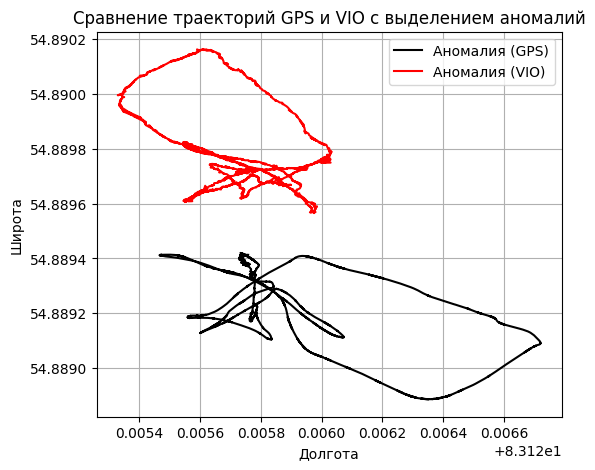

In [52]:
# Списки для данных
gps_lats = lat_GPS.copy()
gps_lons = lon_GPS.copy()
vio_lats = lat_VIO.copy()
vio_lons = lon_VIO.copy()

gps_lats = [ -x + 2 * 54.8894116667 for x in gps_lats]

# Визуализация данных с аномалиями
plt.figure(figsize=(6, 5))

plt.plot(gps_lons, gps_lats, color="black", label="Аномалия (GPS)")
plt.plot(vio_lons, vio_lats, color="red", label="Аномалия (VIO)")

plt.title("Сравнение траекторий GPS и VIO с выделением аномалий")
plt.xlabel("Долгота")
plt.ylabel("Широта")
plt.legend()
plt.grid()
plt.show()

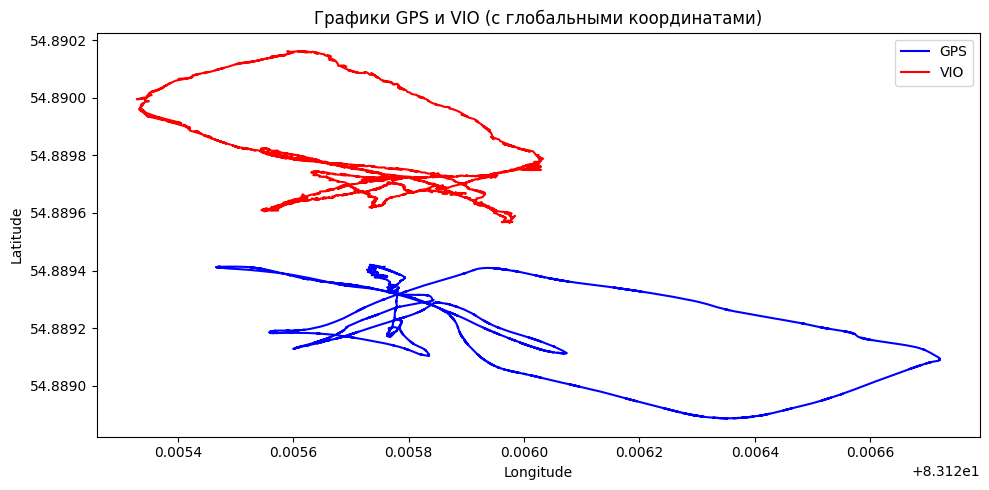

In [15]:
copy_lat_VIO = lat_VIO.copy()
copy_lon_VIO = lon_VIO.copy()

copy_lat_GPS = lat_GPS.copy()
copy_lon_GPS = lon_GPS.copy()

# Создаем фигуру и оси
plt.figure(figsize=(10, 5))

# Преобразование для глобальных координат широты
copy_lat_GPS = [ -x + 2 * 54.8894116667 for x in copy_lat_GPS]

# Рисуем первый график (GPS)
plt.plot(copy_lon_GPS, copy_lat_GPS, label='GPS', color='blue')

# Рисуем второй график (VIO)
plt.plot(copy_lon_VIO, copy_lat_VIO, label='VIO', color='red')

# Добавляем заголовок и метки осей
plt.title('Графики GPS и VIO (с глобальными координатами)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Добавляем легенду
plt.legend()

# Отображение графика
plt.tight_layout()
plt.show()

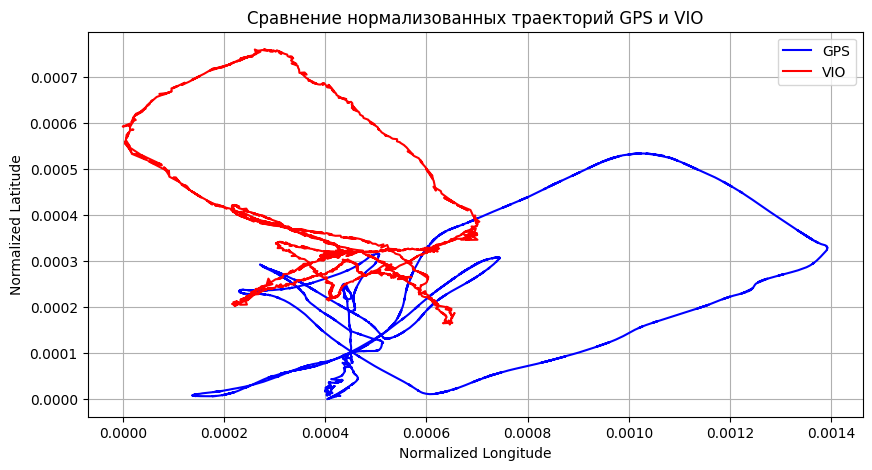

In [16]:
# Найдем минимальные и максимальные значения для обеих систем координат
min_lat = min(min(lat_GPS), min(lat_VIO))
max_lat = max(max(lat_GPS), max(lat_VIO))
min_lon = min(min(lon_GPS), min(lon_VIO))
max_lon = max(max(lon_GPS), max(lon_VIO))

# Нормализуем данные для обоих наборов (вычитая минимальные значения)
norm_lat_GPS = [lat - min_lat for lat in lat_GPS]
norm_lon_GPS = [lon - min_lon for lon in lon_GPS]
norm_lat_VIO = [lat - min_lat for lat in lat_VIO]
norm_lon_VIO = [lon - min_lon for lon in lon_VIO]

plt.figure(figsize=(10, 5))
plt.plot(norm_lon_GPS, norm_lat_GPS, label="GPS", color="blue")
plt.plot(norm_lon_VIO, norm_lat_VIO, label="VIO", color="red")
plt.title("Сравнение нормализованных траекторий GPS и VIO")
plt.xlabel("Normalized Longitude")
plt.ylabel("Normalized Latitude")
plt.legend()
plt.grid()
plt.show()

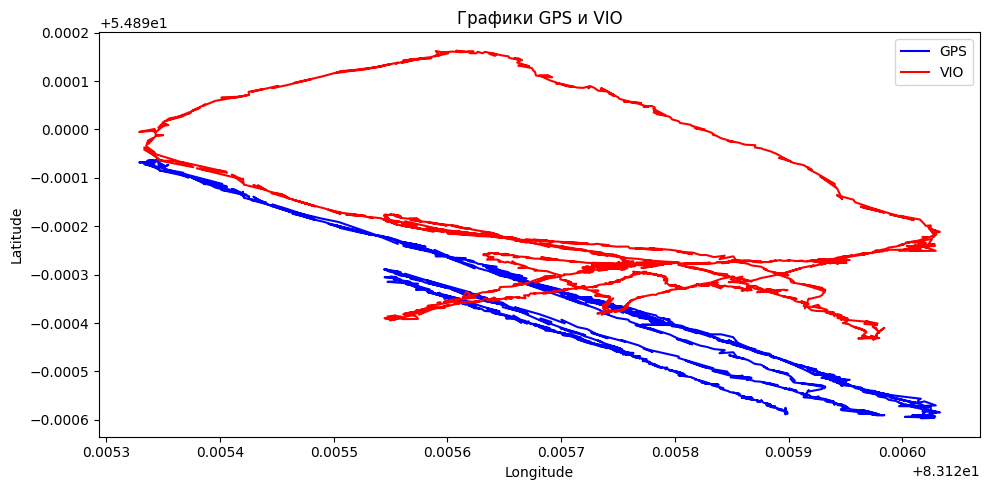

In [17]:
copy_lat_VIO = lat_VIO.copy()
copy_lon_VIO = lon_VIO.copy()

copy_lat_GPS = lat_GPS.copy()
copy_lon_GPS = lon_VIO.copy()

# Create figure and axis
# Создаем фигуру и оси
plt.figure(figsize=(10, 5))
# copy_lat_GPS = [ - x + 2 * 54.8894116667 for x in copy_lat_GPS]

# Рисуем первый график
plt.plot(copy_lon_GPS, copy_lat_GPS, label='GPS', color='blue')

# Рисуем второй график
plt.plot(copy_lon_VIO, copy_lat_VIO, label='VIO', color='red')

# Добавляем заголовок и метки осей
plt.title('Графики GPS и VIO')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Добавляем легенду
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [18]:
# Загрузка констант из файла
with open("vio_gps_constants.json", "r") as f:
    constants = json.load(f)

lat_shift_const = constants["lat_shift"]
lon_shift_const = constants["lon_shift"]
lat_scale_const = constants["lat_scale"]
lon_scale_const = constants["lon_scale"]

# Преобразование VIO данных с использованием констант
transformed_lat_VIO = [(lat - min(lat_VIO)) * lat_scale_const + min(lat_GPS) for lat in lat_VIO]
transformed_lon_VIO = [(lon - min(lon_VIO)) * lon_scale_const + min(lon_GPS) for lon in lon_VIO]

# Учет вращения на 90 градусов
rotation_angle = np.radians(90)  # Угол поворота в радианах
cos_angle = np.cos(rotation_angle)
sin_angle = np.sin(rotation_angle)

rotated_lat_VIO = [
    cos_angle * lat - sin_angle * lon
    for lat, lon in zip(transformed_lat_VIO, transformed_lon_VIO)
]
rotated_lon_VIO = [
    sin_angle * lat + cos_angle * lon
    for lat, lon in zip(transformed_lat_VIO, transformed_lon_VIO)
]

# Копирование данных GPS для работы
copy_lat_GPS = lat_GPS.copy()
copy_lon_GPS = lon_GPS.copy()


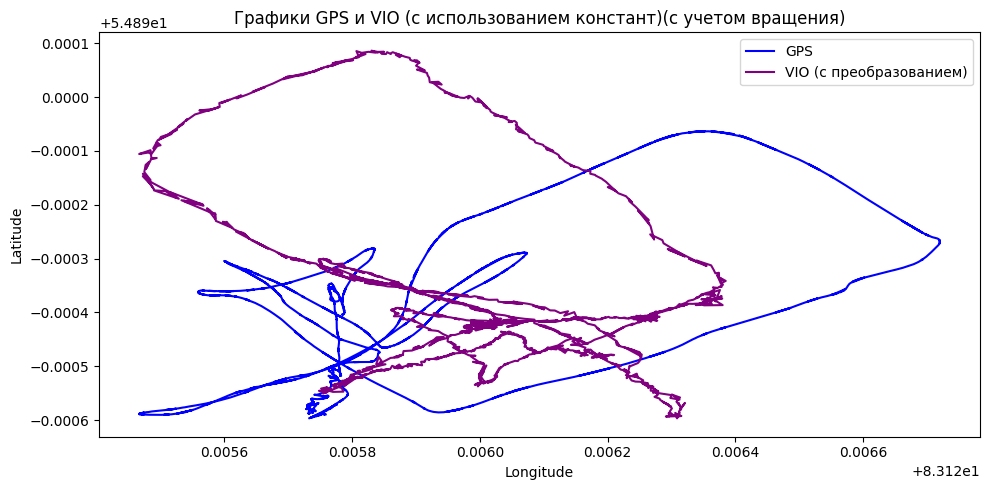

In [19]:
# Создаем фигуру и оси
plt.figure(figsize=(10, 5))

# Рисуем GPS данные
plt.plot(copy_lon_GPS, copy_lat_GPS, label='GPS', color='blue')

# Рисуем VIO данные после применения констант
plt.plot(transformed_lon_VIO, transformed_lat_VIO, label='VIO (с преобразованием)', color='purple')

# Добавляем заголовок и метки осей
plt.title('Графики GPS и VIO (с использованием констант)(с учетом вращения)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Добавляем легенду
plt.legend()

# Отображение графика
plt.tight_layout()
plt.show()

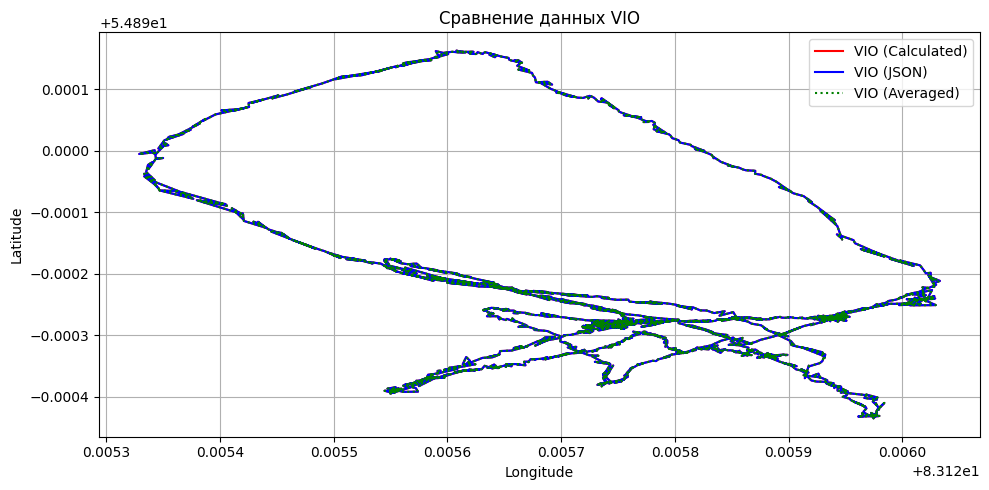

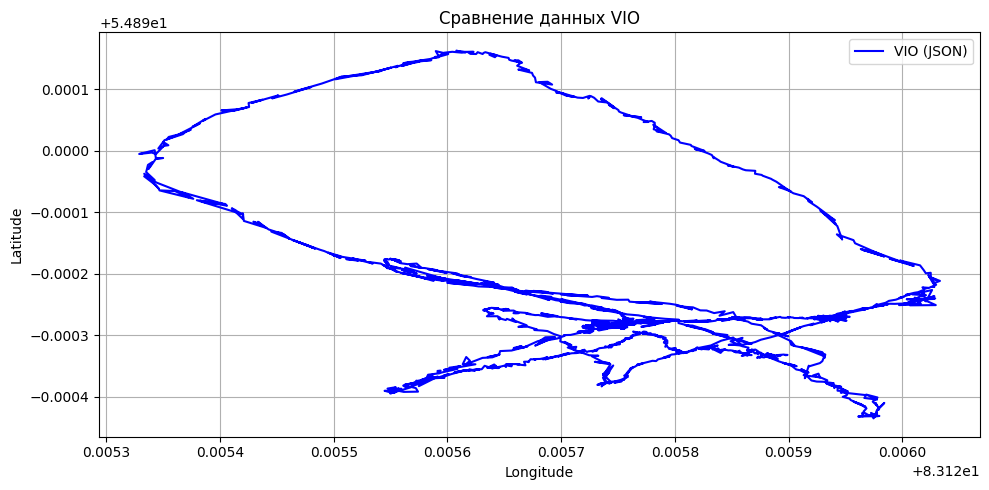

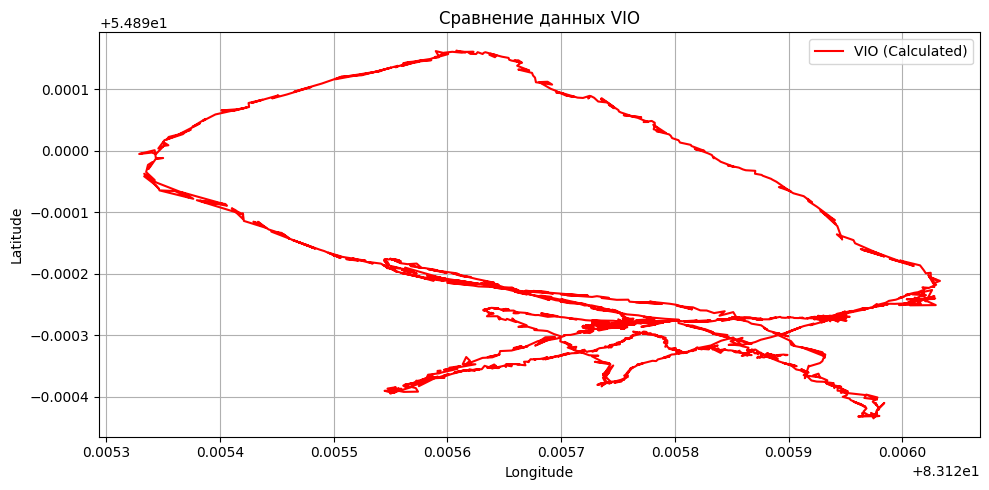

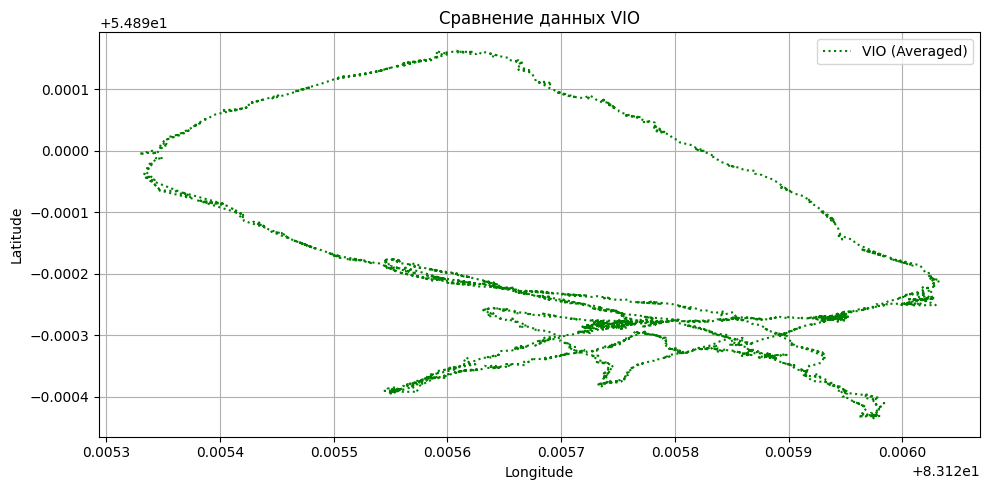

In [20]:
# Списки для усредненных данных
avg_lat = []
avg_lon = []

# Усреднение координат VIO
for json_lat, json_lon, calc_lat, calc_lon in zip(lat_VIO, lon_VIO, lat_VIO, lon_VIO):
    avg_lat.append((json_lat + calc_lat) / 2)
    avg_lon.append((json_lon + calc_lon) / 2)

# Построение графиков
plt.figure(figsize=(10, 5))

# Пересчитанные данные VIO
plt.plot(lon_VIO, lat_VIO, label='VIO (Calculated)', color='red')

# Оригинальные данные VIO из JSON
plt.plot(lon_VIO, lat_VIO, label='VIO (JSON)', color='blue')

# Усредненные данные
plt.plot(avg_lon, avg_lat, label='VIO (Averaged)', color='green', linestyle='dotted')

# Настройка графика
plt.title('Сравнение данных VIO')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Построение графиков
plt.figure(figsize=(10, 5))

# Оригинальные данные VIO из JSON
plt.plot(lon_VIO, lat_VIO, label='VIO (JSON)', color='blue')

# Настройка графика
plt.title('Сравнение данных VIO')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Построение графиков
plt.figure(figsize=(10, 5))

# Пересчитанные данные VIO
plt.plot(lon_VIO, lat_VIO, label='VIO (Calculated)', color='red')

# Настройка графика
plt.title('Сравнение данных VIO')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Построение графиков
plt.figure(figsize=(10, 5))

# Усредненные данные
plt.plot(avg_lon, avg_lat, label='VIO (Averaged)', color='green', linestyle='dotted')

# Настройка графика
plt.title('Сравнение данных VIO')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()